In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import Module
from scipy.sparse import coo_matrix
from scipy.sparse import vstack
from scipy import sparse
import numpy as np
import pandas as pd
from torch.optim import Adam
from torch.nn import MSELoss
import time

np.random.seed(23)

### Data Preprocessing

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class RatingsDataset(Dataset):
    """Ratings Dataset"""

    def __init__(self):
        """
        Args:
            csv_file (string): Path to the csv file with ratings.
        """
        self.csv = pd.read_csv('data/ratings.csv')
        
        self.userId = list(self.csv.userId-1)
        self.movieId = list(self.csv.movieId-1)
        self.ratings = list(self.csv.rating)
        
        self.userNums = np.max(self.userId)+1
        self.movieNums = np.max(self.movieId)+1

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        return {
            'user': self.userId[idx],
            'movie': self.movieId[idx], 
            'rating': self.ratings[idx]
        }
    
    def get_user_number(self):
        return self.userNums
    
    def get_movie_number(self):
        return self.movieNums

In [3]:
rt = pd.read_csv('data/ratings.csv')
rt['userId'] = rt['userId'] - 1
rt['movieId'] = rt['movieId'] - 1

dataset = RatingsDataset()

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [4]:
len(set(dataset.userId))

671

In [5]:
len(set(dataset.movieId))

9066

In [6]:
len(dataset)

100004

In [7]:
dataset.get_user_number()

671

In [8]:
dataset.get_movie_number()

163949

### Model Implementation - Neural Collaborative Filtering 

In [17]:
class NCF(Module):

    def __init__(self, userNum, itemNum, dim=64, first_layer=128):
        super(NCF, self).__init__()
        
        self.uEmbd = nn.Embedding(userNum, dim)
        self.iEmbd = nn.Embedding(itemNum, dim)
        
        self.mf_uEmbd = nn.Embedding(userNum, dim)
        self.mf_iEmbd = nn.Embedding(itemNum, dim)
        
        self.mlp = nn.Sequential(nn.Linear(dim*2, first_layer),
                                       nn.Dropout(0.25),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer, first_layer//2),
                                       nn.Dropout(0.25),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer//2, first_layer//4),
                                       nn.Dropout(0.25),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer//4, first_layer//4))
        
        self.neumf = nn.Linear(dim+first_layer//4, 1)
        
    def forward(self, userIdx,itemIdx):
        
        uembd = self.uEmbd(userIdx)
        
        iembd = self.iEmbd(itemIdx)
        #print(userIdx.shape,itemIdx.shape)
        #print(uembd.shape,iembd.shape)
        embd = torch.cat([uembd, iembd], dim=1)
    
        mlp = self.mlp(embd)
        mf = self.uEmbd(userIdx)*self.iEmbd(itemIdx)
        
        prediction = self.neumf(torch.cat([mlp, mf], dim=1))
        
        return prediction.flatten()

In [18]:
def train(loader, model, optim, loss):
    model.train()
    ls = 0.
    
    for id, batch in enumerate(loader):
        optim.zero_grad()
        prediction = model(batch['user'].cuda(0), batch['movie'].cuda(0))
        loss_ = loss(batch['rating'].float().cuda(0), prediction)
        loss_.backward()
        optim.step()
        ls += loss_.item()
        
    return ls / len(loader)


def evaluate(loader, model, loss):
    model.eval()
    ls = 0.

    with torch.no_grad():
        for id, batch in enumerate(loader):
            prediction = model(batch['user'].cuda(0), batch['movie'].cuda(0))
            loss_ = loss(batch['rating'].float().cuda(0), prediction)
            ls += loss_.item()
            
    return ls / len(loader)

In [19]:
def trainer(trainLoader, valLoader, model, optim, loss, epoch, model_name, verbose=True):
    
    train_losses = []
    val_losses = []

    best_val = np.inf

    for i in range(epoch):
        start = time.time()
        TL = train(trainLoader, model, optim, loss)
        VL = evaluate(valLoader, model, loss)
        
        if verbose:
            print("Epoch {} | Train Loss: {:.3f} - Val Loss: {:.3f} - in {:.3f} mins.".format(i+1, TL, VL, (time.time()-start)/60))

        if VL < best_val:
            torch.save(model.state_dict(), model_name + '.pth.tar')
            best_val = VL

        train_losses.append(TL)
        val_losses.append(VL)
        
    torch.save({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'min_val_loss': min(val_losses)
    }, model_name + '_loss.pth.tar')
        
    return torch.load(model_name + '_loss.pth.tar')

### NeuMF Training

In [25]:
EMBEDDING_DIM = 64

GRID_SEARCH = {
    'batch_size': [128, 256, 512],
    'first_layer': [64, 128, 256],
    'learning_rate': [1e-3, 1e-2]
}

In [26]:
for bs in GRID_SEARCH['batch_size']:
    for layer in GRID_SEARCH['first_layer']:
        for lr in GRID_SEARCH['learning_rate']:
            
            trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
            valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=True)
            
            model = NCF(dataset.get_user_number(), dataset.get_movie_number(), 
                        dim=EMBEDDING_DIM, first_layer=layer).cuda(0)
            
            optim = Adam(model.parameters(), lr=lr)
            loss = nn.L1Loss()
            epoch = 1
            
            ncf_out = trainer(trainLoader, valLoader, model, optim, loss, epoch, 'ncf_model', False)
            
            print("Batch Size: {} | First Layer Neuron: {} | Learning Rate: {} - Min. Val. L1 Loss: {}".format(bs, 
                                                                                                            layer, 
                                                                                                            lr, 
                                                                                                            ncf_out['min_val_loss']))

Batch Size: 128 | First Layer Neuron: 64 | Learning Rate: 0.001 - Min. Val. L1 Loss: 0.8514899901854687
Batch Size: 128 | First Layer Neuron: 64 | Learning Rate: 0.01 - Min. Val. L1 Loss: 0.7646537243555753
Batch Size: 128 | First Layer Neuron: 128 | Learning Rate: 0.001 - Min. Val. L1 Loss: 0.7854857918543693
Batch Size: 128 | First Layer Neuron: 128 | Learning Rate: 0.01 - Min. Val. L1 Loss: 0.7542014622535461
Batch Size: 128 | First Layer Neuron: 256 | Learning Rate: 0.001 - Min. Val. L1 Loss: 0.7660162892097082
Batch Size: 128 | First Layer Neuron: 256 | Learning Rate: 0.01 - Min. Val. L1 Loss: 0.7594847541589004
Batch Size: 256 | First Layer Neuron: 64 | Learning Rate: 0.001 - Min. Val. L1 Loss: 0.8494115617030706
Batch Size: 256 | First Layer Neuron: 64 | Learning Rate: 0.01 - Min. Val. L1 Loss: 0.7643092022492335
Batch Size: 256 | First Layer Neuron: 128 | Learning Rate: 0.001 - Min. Val. L1 Loss: 0.7803178842251117
Batch Size: 256 | First Layer Neuron: 128 | Learning Rate: 0.01

In [27]:
bs = 128
layer = 64
lr = 1e-3
EMBEDDING_DIM = 64

trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
valLoader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=True)

model = NCF(dataset.get_user_number(), dataset.get_movie_number(), 
            dim=EMBEDDING_DIM, first_layer=layer).cuda(0)

optim = Adam(model.parameters(), lr=lr)
loss = nn.L1Loss()
epoch = 5

nf_out = trainer(trainLoader, valLoader, model, optim, loss, epoch, 'ncf_model', False)

print("Batch Size: {} | First Layer Neuron: {} | Learning Rate: {} - Min. Val. L1 Loss: {}".format(bs, 
                                                                                                layer, 
                                                                                                lr, 
                                                                                                nf_out['min_val_loss']))

Batch Size: 128 | First Layer Neuron: 64 | Learning Rate: 0.001 - Min. Val. L1 Loss: 0.731445733935405


In [30]:
for bs in GRID_SEARCH['batch_size']:
    for layer in GRID_SEARCH['first_layer']:
        for lr in GRID_SEARCH['learning_rate']:
            
            trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
            valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=True)
            
            model = NCF(dataset.get_user_number(), dataset.get_movie_number(), 
                        dim=EMBEDDING_DIM, first_layer=layer).cuda(0)
            
            optim = Adam(model.parameters(), lr=lr)
            loss = nn.MSELoss()
            epoch = 1
            
            ncf_out = trainer(trainLoader, valLoader, model, optim, loss, epoch, 'ncf_model', False)
            
            print("Batch Size: {} | First Layer Neuron: {} | Learning Rate: {} - Min. Val. L2 Loss: {}".format(bs, 
                                                                                                            layer, 
                                                                                                            lr, 
                                                                                                            ncf_out['min_val_loss']))

Batch Size: 128 | First Layer Neuron: 64 | Learning Rate: 0.001 - Min. Val. L2 Loss: 0.9989848763514788
Batch Size: 128 | First Layer Neuron: 64 | Learning Rate: 0.01 - Min. Val. L2 Loss: 0.960446508266987
Batch Size: 128 | First Layer Neuron: 128 | Learning Rate: 0.001 - Min. Val. L2 Loss: 0.9854521843103262
Batch Size: 128 | First Layer Neuron: 128 | Learning Rate: 0.01 - Min. Val. L2 Loss: 0.9135276060073804
Batch Size: 128 | First Layer Neuron: 256 | Learning Rate: 0.001 - Min. Val. L2 Loss: 0.9554493224773651
Batch Size: 128 | First Layer Neuron: 256 | Learning Rate: 0.01 - Min. Val. L2 Loss: 0.9155096190098004
Batch Size: 256 | First Layer Neuron: 64 | Learning Rate: 0.001 - Min. Val. L2 Loss: 1.1165091616985126
Batch Size: 256 | First Layer Neuron: 64 | Learning Rate: 0.01 - Min. Val. L2 Loss: 0.9652081827322642
Batch Size: 256 | First Layer Neuron: 128 | Learning Rate: 0.001 - Min. Val. L2 Loss: 1.0169883102942736
Batch Size: 256 | First Layer Neuron: 128 | Learning Rate: 0.01 

In [31]:
bs = 128
layer = 64
lr = 1e-3
EMBEDDING_DIM = 64

trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
valLoader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=True)

model = NCF(dataset.get_user_number(), dataset.get_movie_number(), 
            dim=EMBEDDING_DIM, first_layer=layer).cuda(0)

optim = Adam(model.parameters(), lr=lr)
loss = nn.MSELoss()
epoch = 5

nf_out = trainer(trainLoader, valLoader, model, optim, loss, epoch, 'ncf_model', False)

print("Batch Size: {} | First Layer Neuron: {} | Learning Rate: {} - Min. Val. L2 Loss: {}".format(bs, 
                                                                                                layer, 
                                                                                                lr, 
                                                                                                nf_out['min_val_loss']))

Batch Size: 128 | First Layer Neuron: 64 | Learning Rate: 0.001 - Min. Val. L2 Loss: 0.9085919845562714


### Training Results

In [32]:
nf_out = torch.load('ncf_model_loss.pth.tar')


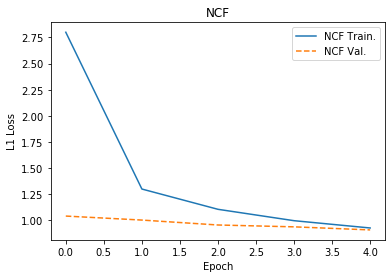

In [33]:
plt.title('NCF')
plt.plot(nf_out['train_losses'], label='NCF Train.')
plt.plot(nf_out['val_losses'], label='NCF Val.', linestyle='--')
_ = plt.ylabel('L1 Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend()
plt.savefig('ncf.png', bbox_inches='tight', dpi=200)

***

## References

[1] _He, Xiangnan, et al. "Neural collaborative filtering." Proceedings of the 26th international conference on world wide web. International World Wide Web Conferences Steering Committee, 2017._
